# Maitriser l’API de twitter pour l’extraction des tweets


In [ ]:
!pip install preprocessor


  Created wheel for preprocessor: filename=preprocessor-1.1.3-cp36-none-any.whl size=4478 sha256=ccfe5d09949202ae3e844361f543d0a7d500a926fd13e13b80830fdcce6ae054
  Stored in directory: /root/.cache/pip/wheels/98/c1/a2/21fbcfd80d76576bbf148991a66f00730f541f265c7600000f
Successfully built preprocessor


In [ ]:
!pip install tweepy


In [ ]:
import preprocessor as p
import statistics
from typing import List
import ssl


In [ ]:
!pip install -U spacy
!python3 -m spacy download en_core_web_sm


     |████████████████████████████████| 10.4MB 5.5MB/s 
     |████████████████████████████████| 1.1MB 39.5MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 12.1MB 3.8MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-cp36-none-any.whl size=12047110 sha256=64ab494e6e9f69f2d616f731d4df26c136e68746a4b68acbbc4d6f5a17d94d8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-j005jb3w/wheels/2b/3f/41/f0b92863355c3ba34bb32b37d8a0c662959da0058202094f46
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tweepy
import csv
import os
import pandas as pd

import seaborn as sns
import re
import spacy
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


from sklearn.metrics import jaccard_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Add your Twitter API credentials
consumer_key = "iuoxy4jNIgJg3hd9MMjOjMqNs" 
consumer_secret = "6inhY4mQw9tp08xP7iTihVYj1wMtA2rAW3vCf6pxK2JLQHLN3r"
access_key = "1015771879-TZ3kFtK5m8Nt0OZThTOcsYkUDu206QaXdZfFdhb"
access_secret = "pMO7jAszm1oqCGwJfHVHnZpFnaDkPHWijfKZlP99opzDY"

# Handling authentication with Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)

# Create a wrapper for the API provided by Twitter
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Define the search term to make the search
search_words = "#"
# Exclude retweets in our search
new_search = search_words + " -filter:retweets"

date_since = "2020-12-8"

# Define until what date we are looking for tweets
date_until = ""

# Total tweets to gather in our search
totalTweets = 100000

# Numbers of tweets to return per page, max is 100. Default is 15.
count = 100

# Filter by language
lang = "en"

geocode = ""

# Filter by recent, popular or mixed.
result_type = "recent"

'''Include info on entities found in Tweets, including hashtags,
links, and mentions. Set to True or False'''
include_entities = True

# Set the name for CSV file  where the tweets will be saved
filename = "Twitter"


# Function for handling pagination in our search
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            print('Reached rate limite. Sleeping for >15 minutes')
            time.sleep(15 * 61)


# Function for make the search using Twitter API
def search_tweets(new_search, date_since):

    # performs the search using the defined variables
    for tweet in limit_handled(tweepy.Cursor(api.search,
                               q=new_search,
                               count=count,
                               tweet_mode='extended',
                               lang=lang,
                               geocode=geocode,
                               result_type=result_type,
                               include_entities=include_entities,
                               since=date_since,
                               until=date_until).items(totalTweets)):

        try:

            # Checks if its a extended tweet (>140 characters)
            content = tweet.full_text

            '''Convert all named and numeric character references
            (e.g. &gt;, &#62;, &#x3e;) in the string s to the
            corresponding Unicode characters'''
            content = (content.replace('&amp;', '&').replace('&lt;', '<')
                       .replace('&gt;', '>').replace('&quot;', '"')
                       .replace('&#39;', "'").replace(';', " ")
                       .replace(r'\u', " ").replace('\u2026', ""))

            # Save other information from the tweet
            user = tweet.author.screen_name
            timeTweet = tweet.created_at
            source = tweet.source
            tweetId = tweet.id
            tweetUrl = "https://twitter.com/statuses/" + str(tweetId)

            # Exclude retweets, too many mentions and too many hashtags
            if not any((('RT @' in content, 'RT' in content,
                       content.count('@') >= 2, content.count('#') >= 3))):

                # Saves the tweet information in a new row of the CSV file
                writer.writerow([content, timeTweet,
                                user, source, tweetId, tweetUrl])

        except Exception as e:
            print('Encountered Exception:', e)
            pass


def work():

    # Opening a CSV file to save the gathered tweets
    with open(filename+".csv", 'w') as file:
        global writer
        writer = csv.writer(file)

        # Add a header row to the CSV
        writer.writerow(["Contenu_", "Date_", "Utilisateur_",
                         "Source_", "ID_", "Tweet URL"])

        # Initializing the Twitter search
        try:
            search_tweets(search_words, date_since)

        # Stop temporarily when hitting Twitter rate Limit
        except tweepy.RateLimitError:
            print("RateLimitError...waiting ~15 minutes to continue")
            time.sleep(1001)
            search_tweets(search_words, date_since)

        # Stop temporarily when getting a timeout or connection error
        except (Timeout, ssl.SSLError, ReadTimeoutError,
                ConnectionError) as exc:
            print("Timeout/connection error...waiting ~15 minutes to continue")
            time.sleep(1001)
            search_tweets(search_words, date_since)

        # Stop temporarily when getting other errors
        except tweepy.TweepError as e:
            if 'Failed to send request:' in e.reason:
                print("Time out error caught.")
                time.sleep(1001)
                search_tweets(search_words, date_since)
            elif'Too Many Requests' in e.reason:
                print("Too many requests, sleeping for 15 min")
                time.sleep(1001)
                search_tweets(search_words, date_since)
            else:
                print(e)
                print("Other error with this user...passing")
                pass


if __name__ == '__main__':

    work()

Rate limit reached. Sleeping for: 853


NameError: ignored

In [97]:
import pandas as pd

In [98]:
 df = pd.read_csv('Twitter.csv')

In [99]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7759 entries, 0 to 7758
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Contenu_      7759 non-null   object
 1   Date_         7759 non-null   object
 2   Utilisateur_  7759 non-null   object
 3   Source_       7756 non-null   object
 4   ID_           7759 non-null   int64 
 5   Tweet URL     7759 non-null   object
dtypes: int64(1), object(5)
memory usage: 363.8+ KB


In [100]:
df.head(1000)


,Contenu_,Date_,Utilisateur_,Source_,ID_,Tweet URL
0,Go like https://t.co/FSIdbJjvrc,2020-12-16 07:51:18,LabronSmith4,Twitter for iPhone,1339115875643875329,https://twitter.com/statuses/1339115875643875329
1,@fuckgogy i will listen to that song till the ...,2020-12-16 07:51:18,jeonoyas,Twitter for iPhone,1339115875358498818,https://twitter.com/statuses/1339115875358498818
2,@tartqglia ikkk i want to see more of her 🥺 sh...,2020-12-16 07:51:18,analovesbsd,Twitter for iPhone,1339115875354501121,https://twitter.com/statuses/1339115875354501121
3,@Faminu_ You knw what i am talking about 😂,2020-12-16 07:51:18,zikirillahi,Twitter for iPhone,1339115875090063362,https://twitter.com/statuses/1339115875090063362
4,what lmAO PLS 😭\n https://t.co/9a8wSceqRD,2020-12-16 07:51:18,woozzcart,Twitter for iPad,1339115875027230720,https://twitter.com/statuses/1339115875027230720
...,...,...,...,...,...,...
995,It’s like my whole life led me to you,2020-12-16 07:51:15,kenxjones,Twitter for iPhone,1339115862595256320,https://twitter.com/statuses/1339115862595256320
996,this feels racist💀✋🏽 https://t.co/TWaQVkjCHG,2020-12-16 07:51:15,hidden_ahgase,Twitter for Android,1339115862591229959,https://twitter.com/statuses/1339115862591229959
997,@nct_menfess join the chat,2020-12-16 07:51:15,bygyulie,Twitter for Android,1339115862578450432,https://twitter.com/statuses/1339115862578450432
998,"@HANBIN_twt_ hubii ? , i miss u so much 🥺",2020-12-16 07:51:15,syipazaa,Twitter for Android,1339115862565953536,https://twitter.com/statuses/1339115862565953536


In [76]:
df.shape

(7759, 6)

In [77]:
df.drop_duplicates(subset='Contenu_',inplace=True)

In [101]:
#First replace all the empty rows with NAN value 
df['Contenu_'].replace('', np.nan, inplace=True)
#Then we drop those rows
df.dropna(subset=['Contenu_'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7759 entries, 0 to 7758
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Contenu_      7759 non-null   object
 1   Date_         7759 non-null   object
 2   Utilisateur_  7759 non-null   object
 3   Source_       7756 non-null   object
 4   ID_           7759 non-null   int64 
 5   Tweet URL     7759 non-null   object
dtypes: int64(1), object(5)
memory usage: 424.3+ KB


In [102]:
df.shape

(7759, 6)

In [103]:
df = pd.DataFrame(tweet_df[['Contenu_', 'Date_','ID_' ]])
df.head()

,Contenu_,Date_,ID_
0,Go like https://t.co/FSIdbJjvrc,2020-12-16 07:51:18,1339115875643875329
1,@fuckgogy i will listen to that song till the ...,2020-12-16 07:51:18,1339115875358498818
2,@tartqglia ikkk i want to see more of her 🥺 sh...,2020-12-16 07:51:18,1339115875354501121
3,@Faminu_ You knw what i am talking about 😂,2020-12-16 07:51:18,1339115875090063362
4,what lmAO PLS 😭\n https://t.co/9a8wSceqRD,2020-12-16 07:51:18,1339115875027230720


In [104]:
df.shape


(4651, 3)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4651 entries, 0 to 4650
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Contenu_  4651 non-null   object
 1   Date_     4651 non-null   object
 2   ID_       4651 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 109.1+ KB


 Tweets Preprocessing and Cleaning


In [106]:
import re

 Removing Twitter Handles (@user)

In [107]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [108]:
# remove twitter handles (@user)
df['handles'] = np.vectorize(remove_pattern)(df['Contenu_'], "@[\w]*")
df.head(1000)

,Contenu_,Date_,ID_,handles
0,Go like https://t.co/FSIdbJjvrc,2020-12-16 07:51:18,1339115875643875329,Go like https://t.co/FSIdbJjvrc
1,@fuckgogy i will listen to that song till the ...,2020-12-16 07:51:18,1339115875358498818,i will listen to that song till the day that ...
2,@tartqglia ikkk i want to see more of her 🥺 sh...,2020-12-16 07:51:18,1339115875354501121,ikkk i want to see more of her 🥺 she’s so pretty
3,@Faminu_ You knw what i am talking about 😂,2020-12-16 07:51:18,1339115875090063362,You knw what i am talking about 😂
4,what lmAO PLS 😭\n https://t.co/9a8wSceqRD,2020-12-16 07:51:18,1339115875027230720,what lmAO PLS 😭\n https://t.co/9a8wSceqRD
...,...,...,...,...
995,It’s like my whole life led me to you,2020-12-16 07:51:15,1339115862595256320,It’s like my whole life led me to you
996,this feels racist💀✋🏽 https://t.co/TWaQVkjCHG,2020-12-16 07:51:15,1339115862591229959,this feels racist💀✋🏽 https://t.co/TWaQVkjCHG
997,@nct_menfess join the chat,2020-12-16 07:51:15,1339115862578450432,join the chat
998,"@HANBIN_twt_ hubii ? , i miss u so much 🥺",2020-12-16 07:51:15,1339115862565953536,"hubii ? , i miss u so much 🥺"


Removing  URLS,Punctuations, Numbers, and Special Characters,Upcase

In [109]:
# remove special characters, numbers, punctuations
df['Tweet_punct'] = df['handles'].str.replace("http\S*", " ")#remove URL
df['Tweet_punct'] = df['Tweet_punct'].str.replace("[^a-zA-Z#]", " ")# Removing Punctuations, Numbers, and Special Characters
df['Tweet_punct'] = df['Tweet_punct'].str.lower()# Removing Upcase
df['Tweet_punct'] = df['Tweet_punct'].str.replace("[^A-Za-z0-9^,!.\/'+-=]", " ")
df['Tweet_punct'] = df['Tweet_punct'].str.replace(r'#([^\s]+)', "")# remove all hashtags
df['Tweet_punct'] = df['Tweet_punct'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')#remove duplicated words in row
from collections import OrderedDict
df['Tweet_punct'] = (df['Tweet_punct'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))#To remove non-consecutive duplicates, I'd suggest a solution involving the OrderedDict data structure
 # remove additional whitespaces in tweets
df['Tweet_punct'] = df['Tweet_punct'].str.replace('[\s]+', ' ')
df.head(1000)

,Contenu_,Date_,ID_,handles,Tweet_punct
0,Go like https://t.co/FSIdbJjvrc,2020-12-16 07:51:18,1339115875643875329,Go like https://t.co/FSIdbJjvrc,go like
1,@fuckgogy i will listen to that song till the ...,2020-12-16 07:51:18,1339115875358498818,i will listen to that song till the day that ...,i will listen to that song till the day d e
2,@tartqglia ikkk i want to see more of her 🥺 sh...,2020-12-16 07:51:18,1339115875354501121,ikkk i want to see more of her 🥺 she’s so pretty,ikkk i want to see more of her she s so pretty
3,@Faminu_ You knw what i am talking about 😂,2020-12-16 07:51:18,1339115875090063362,You knw what i am talking about 😂,you knw what i am talking about
4,what lmAO PLS 😭\n https://t.co/9a8wSceqRD,2020-12-16 07:51:18,1339115875027230720,what lmAO PLS 😭\n https://t.co/9a8wSceqRD,what lmao pls
...,...,...,...,...,...
995,It’s like my whole life led me to you,2020-12-16 07:51:15,1339115862595256320,It’s like my whole life led me to you,it s like my whole life led me to you
996,this feels racist💀✋🏽 https://t.co/TWaQVkjCHG,2020-12-16 07:51:15,1339115862591229959,this feels racist💀✋🏽 https://t.co/TWaQVkjCHG,this feels racist
997,@nct_menfess join the chat,2020-12-16 07:51:15,1339115862578450432,join the chat,join the chat
998,"@HANBIN_twt_ hubii ? , i miss u so much 🥺",2020-12-16 07:51:15,1339115862565953536,"hubii ? , i miss u so much 🥺",hubii i miss u so much


Removing Short Words

In [110]:
df['specif'] = df['Tweet_punct'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head(1000)

,Contenu_,Date_,ID_,handles,Tweet_punct,specif
0,Go like https://t.co/FSIdbJjvrc,2020-12-16 07:51:18,1339115875643875329,Go like https://t.co/FSIdbJjvrc,go like,like
1,@fuckgogy i will listen to that song till the ...,2020-12-16 07:51:18,1339115875358498818,i will listen to that song till the day that ...,i will listen to that song till the day d e,will listen that song till
2,@tartqglia ikkk i want to see more of her 🥺 sh...,2020-12-16 07:51:18,1339115875354501121,ikkk i want to see more of her 🥺 she’s so pretty,ikkk i want to see more of her she s so pretty,ikkk want more pretty
3,@Faminu_ You knw what i am talking about 😂,2020-12-16 07:51:18,1339115875090063362,You knw what i am talking about 😂,you knw what i am talking about,what talking about
4,what lmAO PLS 😭\n https://t.co/9a8wSceqRD,2020-12-16 07:51:18,1339115875027230720,what lmAO PLS 😭\n https://t.co/9a8wSceqRD,what lmao pls,what lmao
...,...,...,...,...,...,...
995,It’s like my whole life led me to you,2020-12-16 07:51:15,1339115862595256320,It’s like my whole life led me to you,it s like my whole life led me to you,like whole life
996,this feels racist💀✋🏽 https://t.co/TWaQVkjCHG,2020-12-16 07:51:15,1339115862591229959,this feels racist💀✋🏽 https://t.co/TWaQVkjCHG,this feels racist,this feels racist
997,@nct_menfess join the chat,2020-12-16 07:51:15,1339115862578450432,join the chat,join the chat,join chat
998,"@HANBIN_twt_ hubii ? , i miss u so much 🥺",2020-12-16 07:51:15,1339115862565953536,"hubii ? , i miss u so much 🥺",hubii i miss u so much,hubii miss much


Tokenization

In [111]:
#df['Tweet_tokenized'] = df['specif'].apply(lambda x: x.split())
tokenized_tweet = df['specif'].apply(lambda x: x.split())
tokenized_tweet.head(1000)


0                                [like]
1      [will, listen, that, song, till]
2            [ikkk, want, more, pretty]
3                [what, talking, about]
4                          [what, lmao]
                     ...               
995                 [like, whole, life]
996               [this, feels, racist]
997                        [join, chat]
998                 [hubii, miss, much]
999                          [neverrrr]
Name: specif, Length: 1000, dtype: object

stopword

In [112]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'having', 'not', 'i', 'who', "doesn't", 'no', 'after', 'has', 'didn', 'have', 'further', 'very', 'about', 'me', 'other', "you've", 'were', 'd', 'before', 'up', 'when', 'haven', 'over', 'wasn', 'had', 'few', 'nor', 'own', "hasn't", "haven't", 'you', 'yourselves', "isn't", 'or', 'shouldn', 'and', 'myself', 'aren', 'against', 'all', 'this', 'off', 'there', 'himself', 'from', 'under', 're', 'between', 'theirs', 'yours', 'once', "don't", 'just', 'herself', 'a', 'themselves', "didn't", "hadn't", 'while', 'ourselves', 'am', 'll', 'weren', 've', 'to', 'mightn', 'what', 'will', 'don', "mustn't", 'them', 'these', 'as', 'down', "that'll", 'most', "needn't", 'with', 'below', 'they', 'hers', 'of', 'couldn', 'mustn', 'only', 'he', 'she', 'now', 'on', 'then', 'those', 'again', "weren't", 'does', 'my', 'same', 'was', 'is', 't', 'wouldn', 'hadn', 'are', 'why', 'which', 'into', 'should', 'during', 'an', 'so', "it's", 'the', 'above', 'isn', 'being', 'out', 'too', 's', 'but', "won't", 'if', 'for', 'where

In [133]:
#stopword.extend(['what', 'year', 'woman', 'girl', 'sixteen', 'yearold', 'weeks', 'week','bitch','fuck','yess'
            # 'treatment', 'associated', 'patients'])
#add words that aren't in the NLTK stopwords list
new_stopwords = ['what', 'year', 'yayyy', 'sixteen', 'yearold', 'weeks', 'week','bitch','fuck','yess','yeah','dontt','ikkk'
             'treatment', 'associated', 'patients','omgg','yeahh','lmao']
new_stopwords_list = stop_words.union(new_stopwords)

In [134]:
def remove_stopwords(text):
    #text = [word for word in text if word not in stopword]
    text = [word for word in text if word not in new_stopwords_list]
    return text
    
Tweet_nonstop = tokenized_tweet.apply(lambda x: remove_stopwords(x))#essaie2
Tweet_nonstop.head(10)

0                                               [like]
1                                 [listen, song, till]
2                                 [ikkk, want, pretty]
3                                            [talking]
4                                                   []
5                   [really, hope, coming, soon, guys]
6                                    [hacked, scammed]
7    [report, suspicious, voter, behavior, website,...
8                                              [speak]
9                      [love, comes, across, bitterly]
Name: specif, dtype: object

In [135]:
Tweet_nonstop = tokenized_tweet.apply(lambda x: remove_stopwords(x)) #essaie1
Tweet_nonstop.head(100)

0                                             [like]
1                               [listen, song, till]
2                               [ikkk, want, pretty]
3                                          [talking]
4                                                 []
                           ...                      
95                       [halloween, outfit, sorted]
96                                                []
97    [riggins, biggest, sweetheart, wiggly, around]
98                                            [love]
99     [advertising, brave, browser, wahmen, prolly]
Name: specif, Length: 100, dtype: object

Stemming and Lammitization¶

In [136]:
ps = nltk.PorterStemmer()

#def stemming(text):
    #text = [ps.stem(word) for word in text]
    #return text
#df['Tweet_stemmed'] = df['Tweet_tokenized'].apply(lambda x: stemming(x))
#df['Tweet_stemmed'] = df['Tweet_nonstop'].apply(lambda x: stemming(x))
#df.head(10)
Tweet_stemme = Tweet_nonstop.apply(lambda x: [ps.stem(i) for i in x]) # stemming essaie2

#Tweet_stemme = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x]) # stemming essaie1
Tweet_stemme.head(1000)

0                    [like]
1      [listen, song, till]
2      [ikkk, want, pretti]
3                    [talk]
4                        []
               ...         
995     [like, whole, life]
996          [feel, racist]
997            [join, chat]
998     [hubii, miss, much]
999              [neverrrr]
Name: specif, Length: 1000, dtype: object

In [137]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text
Tweet_lemmatized = Tweet_stemme.apply(lambda x: lemmatizer(x)) # stemming essaie2
#clean_tweets['Tweet_lemmatized'] = clean_tweets['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
Tweet_lemmatized.head(1000)

0                    [like]
1      [listen, song, till]
2      [ikkk, want, pretti]
3                    [talk]
4                        []
               ...         
995     [like, whole, life]
996          [feel, racist]
997            [join, chat]
998     [hubii, miss, much]
999              [neverrrr]
Name: specif, Length: 1000, dtype: object

In [138]:
for i in range(len(Tweet_stemme)):
    Tweet_stemme[i] = ' '.join(Tweet_stemme[i])

df['Tweet_stemmed'] = Tweet_stemme

In [139]:
df.head(1000)

,Contenu_,Date_,ID_,handles,Tweet_punct,specif,Tweet_stemmed
0,Go like https://t.co/FSIdbJjvrc,2020-12-16 07:51:18,1339115875643875329,Go like https://t.co/FSIdbJjvrc,go like,like,like
1,@fuckgogy i will listen to that song till the ...,2020-12-16 07:51:18,1339115875358498818,i will listen to that song till the day that ...,i will listen to that song till the day d e,will listen that song till,listen song till
2,@tartqglia ikkk i want to see more of her 🥺 sh...,2020-12-16 07:51:18,1339115875354501121,ikkk i want to see more of her 🥺 she’s so pretty,ikkk i want to see more of her she s so pretty,ikkk want more pretty,ikkk want pretti
3,@Faminu_ You knw what i am talking about 😂,2020-12-16 07:51:18,1339115875090063362,You knw what i am talking about 😂,you knw what i am talking about,what talking about,talk
4,what lmAO PLS 😭\n https://t.co/9a8wSceqRD,2020-12-16 07:51:18,1339115875027230720,what lmAO PLS 😭\n https://t.co/9a8wSceqRD,what lmao pls,what lmao,
...,...,...,...,...,...,...,...
995,It’s like my whole life led me to you,2020-12-16 07:51:15,1339115862595256320,It’s like my whole life led me to you,it s like my whole life led me to you,like whole life,like whole life
996,this feels racist💀✋🏽 https://t.co/TWaQVkjCHG,2020-12-16 07:51:15,1339115862591229959,this feels racist💀✋🏽 https://t.co/TWaQVkjCHG,this feels racist,this feels racist,feel racist
997,@nct_menfess join the chat,2020-12-16 07:51:15,1339115862578450432,join the chat,join the chat,join chat,join chat
998,"@HANBIN_twt_ hubii ? , i miss u so much 🥺",2020-12-16 07:51:15,1339115862565953536,"hubii ? , i miss u so much 🥺",hubii i miss u so much,hubii miss much,hubii miss much


In [142]:
#First replace all the empty rows with NAN value 
df['Tweet_stemmed'].replace('', np.nan, inplace=True)
#Then we drop those rows
df.dropna(subset=['Tweet_stemmed'], inplace=True)
df.head(1000)

,Contenu_,Date_,ID_,handles,Tweet_punct,specif,Tweet_stemmed
0,Go like https://t.co/FSIdbJjvrc,2020-12-16 07:51:18,1339115875643875329,Go like https://t.co/FSIdbJjvrc,go like,like,like
1,@fuckgogy i will listen to that song till the ...,2020-12-16 07:51:18,1339115875358498818,i will listen to that song till the day that ...,i will listen to that song till the day d e,will listen that song till,listen song till
2,@tartqglia ikkk i want to see more of her 🥺 sh...,2020-12-16 07:51:18,1339115875354501121,ikkk i want to see more of her 🥺 she’s so pretty,ikkk i want to see more of her she s so pretty,ikkk want more pretty,ikkk want pretti
3,@Faminu_ You knw what i am talking about 😂,2020-12-16 07:51:18,1339115875090063362,You knw what i am talking about 😂,you knw what i am talking about,what talking about,talk
5,@CyberpunkGame Really hope an AI fix is coming...,2020-12-16 07:51:18,1339115875002159104,Really hope an AI fix is coming soon guys...,really hope an ai fix is coming soon guys,really hope coming soon guys,realli hope come soon guy
...,...,...,...,...,...,...,...
1036,Woah https://t.co/Ks4iG2YLHC,2020-12-16 07:51:15,1339115862066831360,Woah https://t.co/Ks4iG2YLHC,woah,woah,woah
1037,@drvyom Hopefully no one forgets to panic! Hop...,2020-12-16 07:51:15,1339115862028996609,Hopefully no one forgets to panic! Hopefully ...,hopefully no one forgets to panic they can rui...,hopefully forgets panic they ruin asymptomatic...,hope forget panic ruin asymptomat peopl christ...
1038,Wishing DCP Abba Kyari and his team all the be...,2020-12-16 07:51:15,1339115862025003008,Wishing DCP Abba Kyari and his team all the be...,wishing dcp abba kyari and his team all the be...,wishing abba kyari team best with,wish abba kyari team best
1039,@sanaswifee PLEASE MOOD I AM BEGGING,2020-12-16 07:51:15,1339115862016581632,PLEASE MOOD I AM BEGGING,please mood i am begging,please mood begging,pleas mood beg


WordCloud

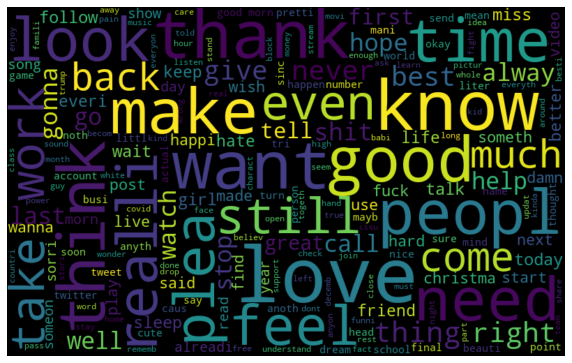

In [143]:
all_words = ' '.join([text for text in df['Tweet_stemmed']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [144]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(df['Tweet_stemmed'])

TF-IDF Features

In [145]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['Tweet_stemmed'])

In [147]:
tf_idf_norm = normalize(tfidf)
tf_idf_array = tf_idf_norm.toarray()

vector = pd.DataFrame(tf_idf_array,
                     columns = tfidf_vectorizer.get_feature_names())
vector.head()

,abl,absolut,accept,access,account,act,activ,actual,ad,address,...,worth,write,wrong,wrote,yall,year,yesss,yesterday,young,youtub
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
vector.describe()

,abl,absolut,accept,access,account,act,activ,actual,ad,address,...,worth,write,wrong,wrote,yall,year,yesss,yesterday,young,youtub
count,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,...,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000,4452.000000
mean,0.001147,0.001774,0.000760,0.000434,0.003089,0.000629,0.001314,0.002872,0.000602,0.000890,...,0.000707,0.001355,0.001860,0.000615,0.000961,0.003461,0.000952,0.001200,0.000932,0.000815
std,0.022768,0.036042,0.018511,0.013086,0.039654,0.017898,0.028054,0.038651,0.015266,0.022332,...,0.020944,0.026447,0.032301,0.017576,0.023121,0.044285,0.028787,0.022423,0.023936,0.020227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.631884,1.000000,0.694882,0.485284,1.000000,0.740700,1.000000,1.000000,0.453879,0.771783,...,1.000000,0.717330,1.000000,0.716520,0.721363,1.000000,1.000000,0.680656,1.000000,0.721363


Model Building

In [149]:
class Kmeans:
    ''' K Means Clustering
    
    Parameters
    -------------------
        k: int, # of clusters
        <
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithms, default: 200
        
    Attributes
    ------------------
        centroids: array, k, number_features
        
        cluster_labels: label for each data point
        
    '''
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
    def intialize_centroids(self,data):
        
        '''Randomly Initialize Centroids
        
        Parameters
        --------------
        data: array or matrix, number_rows, number_features
        
        Returns
        -------------
        centroids: array of k centroids chosen as random data points
        '''
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]
        
        return self.centroids
    
    def assign_clusters(self,data):
        '''Compute distance of data from clusters and assign data point 
        to closest cluster.
        
        Parameters 
        ------------
        data: array or matrix, number_rows, number_features
        
        Returns 
        ------------
        cluster_labels: index which minimizes the distance of data to each cluster
        
        '''
        
        if data.ndim == 1:
            data = data.reshape(-1,1)
            
        dist_to_centroid = pairwise_distances(data,self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return self.cluster_labels
    
    def update_centroids(self,data):
        '''Computes average of all data points in cluster and assigns 
           new centroids as average of data points
           
           Parameters
           -------------
           data: array or matirx, number_rows, number_features
           
           Returns
           -------------
           centroids: array, k, number_features
           '''
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        return self.centroids
    
    def predict(self,data):
        '''Predict which cluster data point belongs to
        
        Parameters
        --------------
        data: array or matirx, number_rows, number_features
        
        Returns
        -------------
        cluster_labels: index which minimizes the distance of data to each
        cluster
        '''
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        '''
        This function contains the main loop to fit the algorithm
        Implements initialize centroids and update_centroids according 
        to max_iter
        ---------------------
        
        Returns
        ------------
        instance of kmeans class
        
        '''
        self.centroids = self.intialize_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):
            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)
            if iter % 100 == 0:
                print('Running Model Iteration %d ' %iter)
        print('Model finished running')
        return self

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


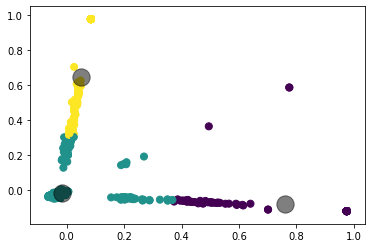

In [150]:
# Own Impementation

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(3, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.5)

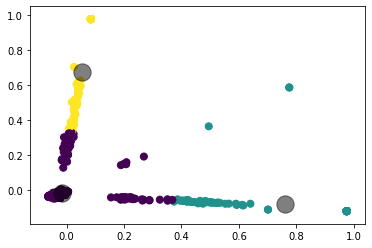

In [151]:
# SKlearn implementation

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto') 
fitted = kmeans.fit(Y_sklearn)
kmeans_prediction = kmeans.predict(Y_sklearn)

skcenters = fitted.cluster_centers_

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=kmeans_prediction, s=50, cmap='viridis')
plt.scatter(skcenters[:, 0], skcenters[:, 1], c='black', s=300, alpha=0.5)

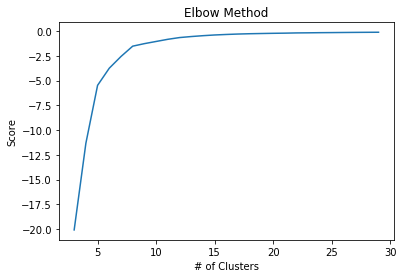

In [152]:
# find out ideal number of clusters using Elbow Method
num_clusters = range(3, 30)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in num_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(num_clusters, score)
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

Top Words in Each Cluster: KMeans¶


In [153]:
# function that identifies the features with the highest mean tf_idf 
# scores across each cluster
def get_top_feats_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        feats = tfidf_vectorizer.get_feature_names()
        best_feats = [(feats[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_feats, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

kmeans_dfs = get_top_feats_cluster(tf_idf_array, kmeans_prediction, 15)


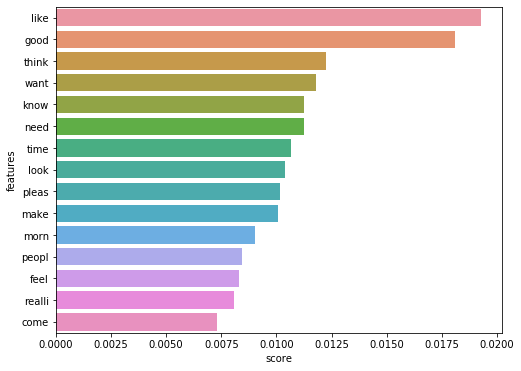

In [154]:
#Cluster 1¶
plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=kmeans_dfs[0][:15]);

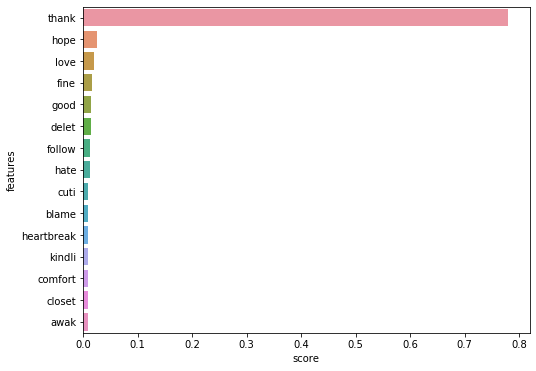

In [155]:
#Cluster 2
plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=kmeans_dfs[1][:15]);

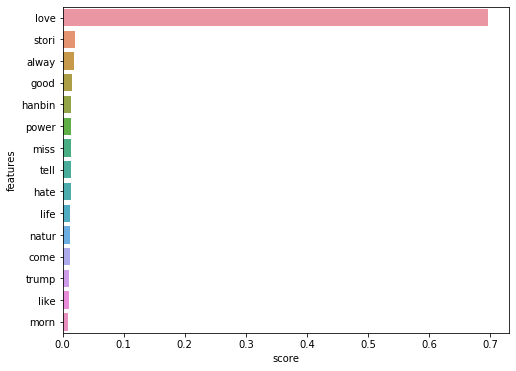

In [156]:
#Cluster 3
plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=kmeans_dfs[2][:15]);

In [157]:
words = tfidf_vectorizer.get_feature_names()

In [160]:
print(words[250:300])


['easi', 'edit', 'educ', 'elect', 'elit', 'els', 'embarrass', 'emot', 'end', 'energi', 'english', 'enjoy', 'entir', 'episod', 'especi', 'event', 'everi', 'everybodi', 'everyday', 'everyon', 'everyth', 'everywher', 'evid', 'evil', 'exactli', 'exam', 'excit', 'excus', 'exhaust', 'exist', 'expect', 'experi', 'expert', 'explain', 'extra', 'eye', 'face', 'fact', 'fail', 'fair', 'faith', 'fake', 'fall', 'famili', 'fan', 'farmer', 'fast', 'father', 'fault', 'fave']


In [161]:
kmeans = KMeans(n_clusters = 3, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(tf_idf_array)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : love, good, think, want, know, need, time, pleas, make, morn, look, peopl, come, miss, realli, shit, feel, wait, happi, work, sleep, great, best, stop, gonna
1 : like, look, feel, realli, sound, make, thing, think, charact, peopl, girl, tweet, tell, want, love, follow, need, alway, shit, caus, mani, comment, minut, watch, right
2 : thank, hope, love, fine, good, delet, follow, hate, cuti, heartbreak, blame, kindli, closet, comfort, awak, thread, album, remind, share, littl, mani, noth, friend, post, lucki


In [162]:
kmeans = KMeans(n_clusters = 5, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : like, think, know, time, make, look, realli, peopl, feel, shit, miss, come, happi, work, wait, gonna, best, watch, great, stop, thing, right, sleep, follow, alway
1 : want, pleas, sleep, come, like, play, peopl, time, look, mood, send, person, right, dont, think, watch, tweet, tell, feel, match, girl, share, account, money, help
2 : thank, good, morn, hope, night, luck, afternoon, soon, friend, damn, thing, look, care, today, point, news, fine, kindli, noth, kind, christma, think, feel, delet, everyon
3 : love, stori, alway, thank, life, wanna, good, hope, hanbin, power, miss, tell, hate, natur, come, right, trump, like, understand, human, amaz, morn, make, everyon, beauti
4 : need, backup, battl, help, bahamut, life, like, say, time, feel, complet, friend, sleep, peopl, sold, anyth, alway, work, line, drag, love, realli, use, alreadi, know


In [163]:
kmeans = KMeans(n_clusters = 10, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : love, need, know, time, make, look, miss, peopl, happi, wait, work, best, feel, realli, great, stop, gonna, sleep, right, watch, alway, help, better, nice, follow
1 : like, look, feel, realli, make, sound, tell, love, follow, comment, thing, minut, peopl, need, morn, mani, girl, life, tweet, annoy, watch, work, dress, tast, help
2 : good, morn, luck, night, hope, thing, look, damn, love, care, today, know, point, afternoon, friend, news, make, great, soon, feel, wednesday, happen, pretti, movi, super
3 : mind, lose, open, come, long, machin, thank, need, stick, realli, feel, someth, stori, care, fish, time, return, busi, finger, selfi, gonna, button, pictur, cover, togeth
4 : want, time, like, sleep, dont, right, money, movi, good, peopl, girl, idea, know, corner, problem, nobodi, wait, stori, sinc, make, word, listen, fail, alway, child
5 : come, pretti, hope, soon, sure, thing, realli, today, fuck, talk, gonna, power, love, like, thank, wait, send, say, live, ask, anyth, day, mis

In [164]:
kmeans = KMeans(n_clusters = 15, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : wing, cours, enjoy, like, work, come, shit, cute, song, wanna, read, vibe, rain, tast, wake, scene, kiss, laugh, backup, place, music, star, holiday, voic, middl
1 : mouth, leav, someth, friday, friend, fuck, fuckin, funni, youtub, free, futur, gain, game, gave, gener, gift, freedom, form, forward, glad, forgot, forget, foreign, forc, fool
2 : like, think, want, know, need, look, make, peopl, realli, work, best, happi, wait, stop, sleep, great, right, alway, watch, better, follow, thing, girl, nice, talk
3 : gonna, watch, make, honestli, think, say, wait, everyth, stop, come, thing, peopl, photo, lip, fix, shower, lord, wear, like, phone, game, damn, stream, tell, sure
4 : help, need, send, ignor, pleas, home, sure, kid, gain, someon, wish, speak, joke, realli, homi, like, okay, bring, winter, anyon, attack, post, gotta, scream, shit
5 : morn, wake, dark, make, like, great, tough, mate, pink, blue, gotta, start, enjoy, noth, minut, photo, upset, gain, besti, struggl, retweet, showe

In [165]:
kmeans = KMeans(n_clusters = 20, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : like, need, want, time, make, peopl, feel, realli, shit, wait, best, work, watch, come, sleep, gonna, help, stop, alway, great, follow, right, tell, thing, better
1 : miss, shot, scare, love, jungkook, door, king, besti, dont, point, actual, sinc, thing, use, play, damn, come, illeg, return, mama, write, ride, state, tree, happi
2 : think, stop, peopl, time, like, someth, pretti, bout, voic, make, star, good, thing, know, gonna, use, work, night, tomorrow, realli, littl, stuff, sound, organis, rememb
3 : transform, stori, understand, dream, month, someon, live, togeth, nigga, fan, messag, save, trump, black, bore, told, season, chang, goe, charact, learn, stan, line, repli, smart
4 : cri, friend, seen, clearli, scream, group, like, emot, cool, walk, shit, seven, togeth, pleas, lock, tini, ask, beauti, away, nigga, start, charact, sound, hurt, video
5 : love, stori, alway, power, tell, hate, come, trump, color, crush, queen, dude, danc, peac, nope, king, hanbin, content, congrat, an

In [166]:
kmeans = KMeans(n_clusters = 25, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : valu, goe, youtub, free, gift, gener, gave, game, gain, futur, funni, fuckin, fuck, friend, friday, freedom, forward, glad, form, forgot, forget, foreign, forc, fool, food
1 : think, want, need, know, time, make, peopl, look, miss, happi, feel, work, best, stop, right, great, wait, realli, help, alway, better, nice, thing, follow, sorri
2 : come, hope, soon, pleas, thing, realli, power, love, like, mind, wait, send, ask, anyth, miss, talk, peopl, thank, guy, live, favorit, want, lmaoo, nder, home
3 : okay, hope, heart, realli, hug, type, whenev, sweet, total, onlin, fine, class, comment, help, focu, collect, rain, probabl, allow, busi, readi, stori, follow, think, twitter
4 : like, look, feel, realli, sound, tell, mani, need, think, follow, annoy, caus, minut, thing, make, comment, retweet, want, tri, life, sorri, right, charact, tast, exist
5 : happen, good, follow, awak, wake, night, tell, wait, need, pic, replac, light, okay, didnt, flow, goodby, brother, today, let, month, worr

In [167]:
kmeans = KMeans(n_clusters =30, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : hate, life, fuck, love, face, thank, alreadi, mask, rest, read, suppos, realli, open, homi, school, friend, peopl, stop, line, come, blow, favourit, drunk, agre, stan
1 : tell, like, talk, stop, love, spot, sent, laugh, book, stori, need, tri, happen, perform, post, major, gonna, bitch, stream, suck, tweet, scene, yall, time, everywher
2 : pleas, come, tweet, match, play, person, send, gift, peopl, cute, noth, look, promis, remov, attack, love, boss, contact, mood, wake, share, check, help, like, want
3 : know, time, look, make, miss, peopl, work, best, come, realli, stop, right, better, gonna, nice, alway, thing, help, girl, post, video, said, talk, christma, beauti
4 : true, besti, check, leader, funni, block, said, anybodi, miss, self, fact, word, need, past, noth, mean, proof, talk, good, thank, follow, life, love, everi, sleep
5 : hard, work, make, home, sound, know, gorgeou, match, read, master, feel, clearli, success, account, best, laugh, realli, readi, come, need, sinc, so